![SCAN-Unit](img/scan-unit-logo.png "SCAN-Unit")

# SCAN-Unit Data Science Dojo

# Chapter 3. fMRI second level analysis - Part Two

### Time Series and Correlation Matrices

In this exercise we are going to work with the "development_fmri" dataset wich comes with nilearn. We will use the things we learned in the previous chapters to visualize and transform the data, to work out the questions we will be asking.

We will use an atlas with ROIs and transform our data into a timeseries showing activation in all these ROIs. With this time series we can also calculate and visualize a correlation matrix. First, we will do this with only one subjects and then we will try to calculate a mean correlation matrix for all 20 subjects. 

Let's get started with loading our libraries and dataset. 

In [2]:
%matplotlib inline
from nilearn import datasets
from nilearn import plotting
from nilearn import image
import numpy as np
import pandas as pd
from scipy import stats
dev_fmri = datasets.fetch_development_fmri(n_subjects=20)
print('Datasets are stored in: %r' % datasets.get_data_dirs())

Datasets are stored in: ['/home/niklasl96/nilearn_data']


First of all we have a look at the data we just imported. We already know where it is stored, but what exactly does the "dev_fmri" variable contain?

In [3]:
dev_fmri

{'func': ['/home/niklasl96/nilearn_data/development_fmri/development_fmri/sub-pixar123_task-pixar_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz',
  '/home/niklasl96/nilearn_data/development_fmri/development_fmri/sub-pixar124_task-pixar_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz',
  '/home/niklasl96/nilearn_data/development_fmri/development_fmri/sub-pixar125_task-pixar_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz',
  '/home/niklasl96/nilearn_data/development_fmri/development_fmri/sub-pixar126_task-pixar_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz',
  '/home/niklasl96/nilearn_data/development_fmri/development_fmri/sub-pixar001_task-pixar_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz',
  '/home/niklasl96/nilearn_data/development_fmri/development_fmri/sub-pixar002_task-pixar_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz',
  '/home/niklasl96/nilearn_data/development_fmri/development_fmri/sub-pixar003_task-pixar_space-MNI152NLin2009cAsym_desc-preproc_bold.

So our variable contains a whole lot of information. For each of the n=20 subjects we have a filepath to a "func" and a "confounds" file. Then there also is a third list containing additional information. 

We will need the func-files and confounds later on so let's just define variables for them.

In [4]:
func_filenames = dev_fmri.func
confounds = dev_fmri.confounds

For the atlas we pick the Harvard Oxford Atlas that comes with nilearn. To import it we use *dataset.fetch* and then define variables containing the maps and labels of the ROIs. We will use this information later to assign a activation pattern to a region and visualize it this way.

Atlas ROIs are located at: /home/niklasl96/nilearn_data/fsl/data/atlases/HarvardOxford/HarvardOxford-cort-maxprob-thr25-2mm.nii.gz


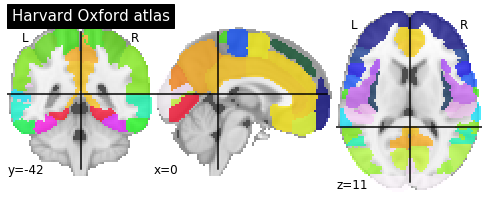

In [5]:
dataset = datasets.fetch_atlas_harvard_oxford('cort-maxprob-thr25-2mm')
atlas = dataset.maps
labels = dataset.labels

print('Atlas ROIs are located at: %s' % atlas)

plotting.plot_roi(atlas, title="Harvard Oxford atlas")
plotting.show()

#### Time Series for subjects separately

Now we will learn a new tool from the nilearn library - the NiftiLabelsMasker. With this, we can create a mask from the atlas, containing the ROIs. We will also use the *fit_transform* command to transform our data into a two dimensional time-series.

Attention: 2D in this case means a list of brain areas containing a list of values for our activation over time!

In [22]:
from nilearn.input_data import NiftiLabelsMasker
masker = NiftiLabelsMasker(labels_img=atlas, standardize=True,
                           memory='nilearn_cache', verbose=5)
time_series = masker.fit_transform(func_filenames[0], confounds=confounds)
print(time_series.shape)

[NiftiLabelsMasker.fit_transform] loading data from /home/niklasl96/nilearn_data/fsl/data/atlases/HarvardOxford/HarvardOxford-cort-maxprob-thr25-2mm.nii.gz
Resampling labels
[Memory]0.0s, 0.0min    : Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
(168, 48)


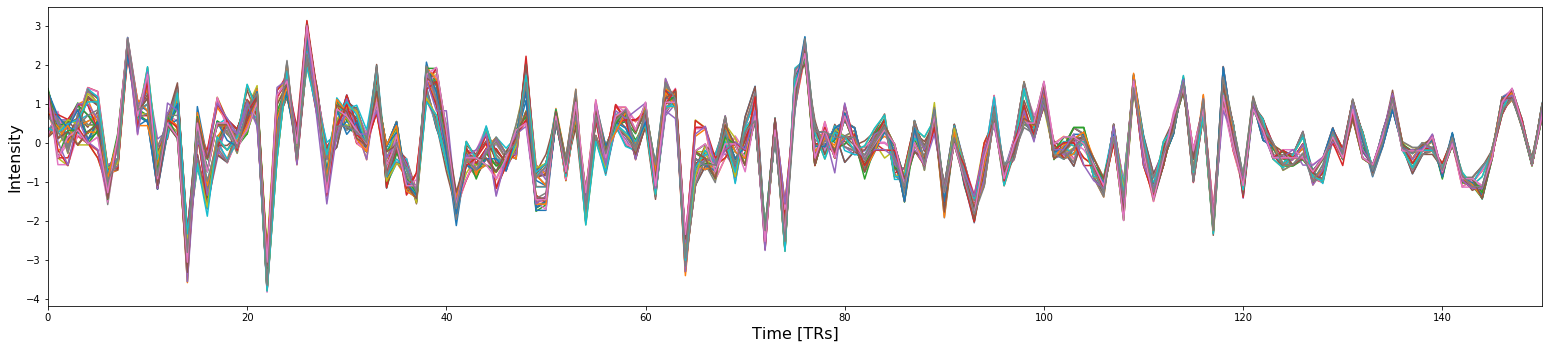

In [23]:
import matplotlib.pyplot as plt
plt.figure(figsize=(25,5))
plt.plot(time_series[:, :])
plt.xlabel('Time [TRs]', fontsize=16)
plt.ylabel('Intensity', fontsize=16)
plt.xlim(0, 150)
plt.subplots_adjust(bottom=.12, top=.95, right=.95, left=.12)

Something seems off here. Take a moment and look at the activation pattern of all our ROIs. Imagine a fMRI scan over time and think about the output you would expect. This pattern seems way to homogeneous. It suggests that something is overshadowing our recording. A measurement error of some sort. What variable are we including in our calculations that corrects these errors or noise? Confounds.

When you have a look at our *fit.transform* function you'll see that we took fMRI data from the first subject but then for confounds we forgot to specify for that subject. When we change that, the time-series should look like we want it to.

[NiftiLabelsMasker.fit_transform] loading data from /home/niklasl96/nilearn_data/fsl/data/atlases/HarvardOxford/HarvardOxford-cort-maxprob-thr25-2mm.nii.gz
Resampling labels
[Memory]0.0s, 0.0min    : Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
(168, 48)


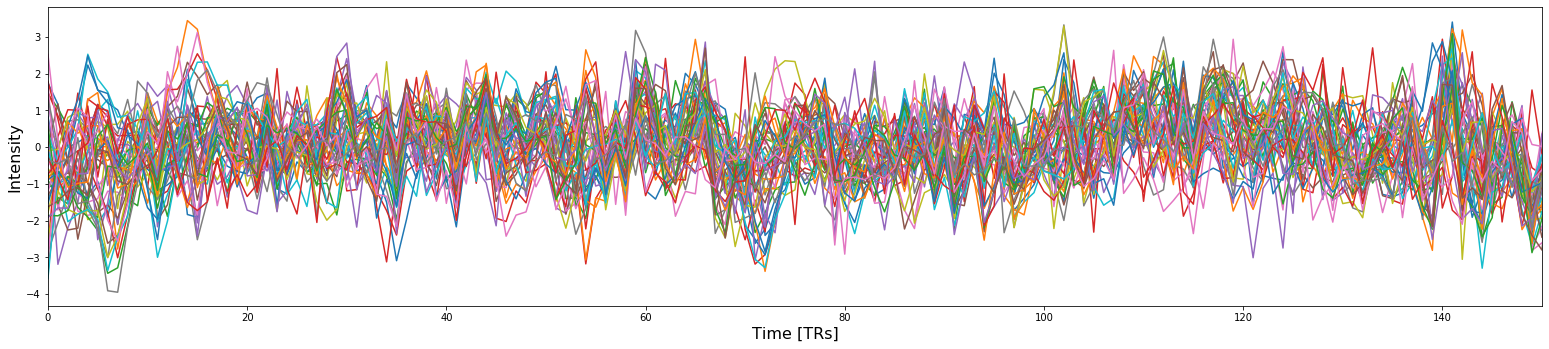

In [25]:
from nilearn.input_data import NiftiLabelsMasker
masker = NiftiLabelsMasker(labels_img=atlas, standardize=True,
                           memory='nilearn_cache', verbose=5)
time_series = masker.fit_transform(func_filenames[0], confounds=confounds[0])
print(time_series.shape)

plt.figure(figsize=(25,5))
plt.plot(time_series[:, :])
plt.xlabel('Time [TRs]', fontsize=16)
plt.ylabel('Intensity', fontsize=16)
plt.xlim(0, 150)
plt.subplots_adjust(bottom=.12, top=.95, right=.95, left=.12)

#### Global Activation

With this time series we can quickly calculate a mean global activation of all our ROIs. This can be used for reduce the noise in our data by regress the global signal out of our ROI signals.

When we use the *np.mean* function be aware of the axis you choose. With the axis you can select which dimension is the target of the function.

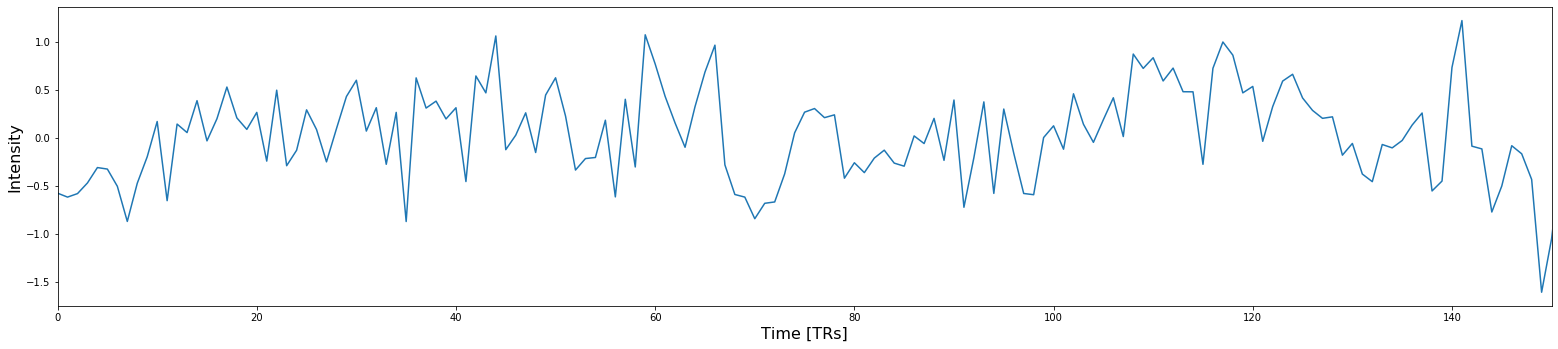

In [26]:
global_signal = np.mean(time_series, axis=1)
plt.figure(figsize=(25,5))
plt.plot(global_signal)
plt.xlabel('Time [TRs]', fontsize=16)
plt.ylabel('Intensity', fontsize=16)
plt.xlim(0, 150)
plt.subplots_adjust(bottom=.12, top=.95, right=.95, left=.12)

#### Correlation Matrix and Connectome for subjects seperately

For visualizing the correlative activation patterns in our ROIs we can use the *nilearn.connectome* function. We just define the kind of connectivity we want to display - in our case "correlation". Then we take our time-series and transform it into a correlation matrix with the *.fit_transform* command we already know from transforming our data into said time-series. At last we can plot a useful matrix.

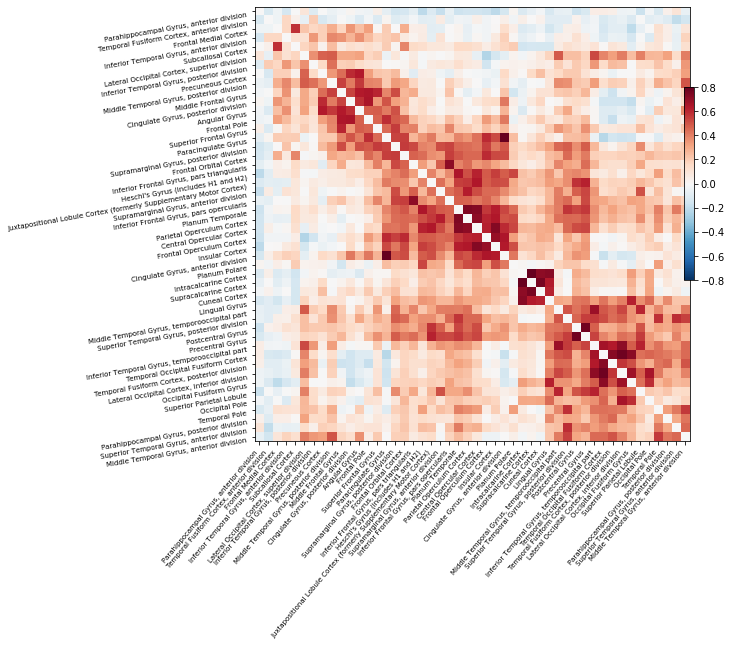

In [28]:
from nilearn.connectome import ConnectivityMeasure
correlation_measure = ConnectivityMeasure(kind='correlation')
correlation_matrix = correlation_measure.fit_transform([time_series])[0]

np.fill_diagonal(correlation_matrix, 0)
plotting.plot_matrix(correlation_matrix, figure=(10,8), labels=labels[1:], vmax=0.8, vmin=-0.8, reorder=True)

#### Mean Connectome for all Subjects

How can we produce a mean connectome for all subjects? We can use a for-loop to transform each nifti file (with confounds) of each subject into a time-series and save it into a numpy list. Then we could simply use *np.mean* along the axis of our n subjects and plot the connectome. BUT, this way we would create a very big numpy array which, under circumstances, can take up a huge part of our computers memory. Now we have a rather small sample size so it should be no problem, but in terms of data management there is a better way to tackle this problem:

Instead of using the for-loop to make a 3D array of n=20 times the data we have and then calculating a mean, we can use it to calculate 20 connectomes and save those into a list. But first things first. We define an empty list and start with a for-loop that prints a number for every subject file we have.


In [31]:
list = []
for n,a in enumerate(func_filenames):
    print(n)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


Next, we tell the for-loop to save the output into a list. For this, we use *.append()*.

In [32]:
list = []
for n,a in enumerate(func_filenames):
    print(n)
    list.append(n)
list

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

Then we swap out the *print()* command with our *masker.fit_transform()* function and tell it to use [n] func_filenames and [n] confounds. We define a variable for these time series so we can utilize them in the next function. The next function will be *list.append* but we swap the "n" with the *correlation_measure.fit_transform* function and give it the "time_series" variable to transform along the first axis. To avoid confusion with the time series variable we defined previously, we give it a clear name.

In [34]:
list = []
correlation_measure = ConnectivityMeasure(kind='correlation')
for n,a in enumerate(func_filenames):
    matrices_time_series = masker.fit_transform(func_filenames[n], confounds=confounds[n])
    list.append(correlation_measure.fit_transform([matrices_time_series])[0])
list

[NiftiLabelsMasker.fit_transform] loading data from /home/niklasl96/nilearn_data/fsl/data/atlases/HarvardOxford/HarvardOxford-cort-maxprob-thr25-2mm.nii.gz
[Memory]1454677.9s, 24244.6min: Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
[NiftiLabelsMasker.fit_transform] loading data from /home/niklasl96/nilearn_data/fsl/data/atlases/HarvardOxford/HarvardOxford-cort-maxprob-thr25-2mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.input_data.base_masker.filter_and_extract...
filter_and_extract('/home/niklasl96/nilearn_data/development_fmri/development_fmri/sub-pixar124_task-pixar_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'labels_img': '/home/niklasl96/nilearn_data/fsl/data/atlases/HarvardOxford/HarvardOxford-cort-maxprob-thr25-2mm.nii.gz',
  'low_pass': None,
  'mask

[array([[1.        , 0.24401723, 0.46565244, ..., 0.18434112, 0.11877049,
         0.12084025],
        [0.24401723, 1.        , 0.17506962, ..., 0.62585453, 0.21552319,
         0.17149528],
        [0.46565244, 0.17506962, 1.        , ..., 0.21508836, 0.01887423,
         0.11149619],
        ...,
        [0.18434112, 0.62585453, 0.21508836, ..., 1.        , 0.17465087,
         0.23575077],
        [0.11877049, 0.21552319, 0.01887423, ..., 0.17465087, 1.        ,
         0.30173617],
        [0.12084025, 0.17149528, 0.11149619, ..., 0.23575077, 0.30173617,
         1.        ]]),
 array([[ 1.        ,  0.12928138,  0.49919827, ..., -0.03149816,
         -0.10148599,  0.21665364],
        [ 0.12928138,  1.        , -0.00645024, ...,  0.39516554,
         -0.20168049, -0.1840059 ],
        [ 0.49919827, -0.00645024,  1.        , ..., -0.20720617,
         -0.20953005, -0.0551076 ],
        ...,
        [-0.03149816,  0.39516554, -0.20720617, ...,  1.        ,
         -0.00304797, -0

Let's check if our list contains the right information. We can use *len()* to determine the number of positions in our list. There should be 20 for n=20 subjects.

In [35]:
len(list)

20

At first glance it looked like everything worked. We now proceed with calculating a mean of our list along the axis of our 20 subjects. The fact that *len(list)* is 20 tells us that the first axis (axis=0) should give us the right output).

With the mean of our list we can then plot the correlation matrix like we did before.

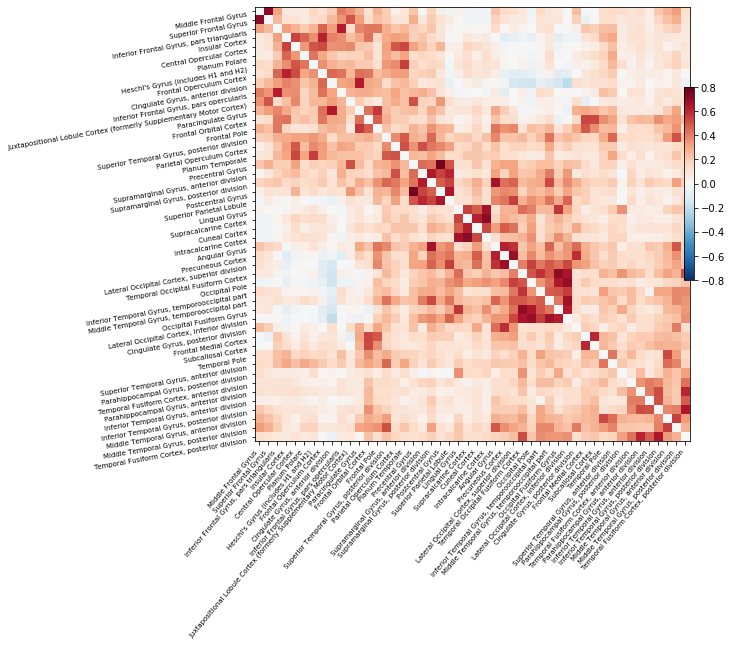

In [36]:
matrices_mean = np.mean(list, axis=0)
np.fill_diagonal(matrices_mean, 0)
plotting.plot_matrix(matrices_mean, figure=(10,8), labels=labels[1:], vmax=0.8, vmin=-0.8, reorder=True)